In [1]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

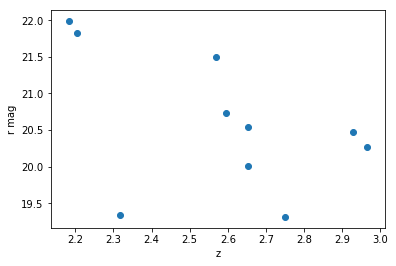

In [3]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 10
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('r mag');

In [4]:
# add the fiducial quasar SED model from BOSS DR9
# need to set forestseed if the forest transmission sightlines are to be reproducible
sedVars = get_BossDr9_model_vars(qsos,wave,0,forestseed=192837465,verbose=1)
qsos.addVars(sedVars)

Generating 10 sightlines


In [5]:
# define photometry in DECam and WISE systems
qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])

In [6]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.2181253, rms = 0.0295074, |max| = 0.2719755
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0175531, rms = 0.0119108, |max| = 0.0362774
buildSpectra iteration  3  out of  3
--> delta mag mean = -0.0004554, rms = 0.0004496, |max| = 0.0012965


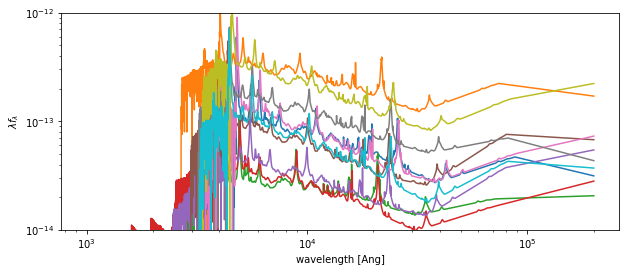

In [7]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

In [8]:
# the parameter values for each spectrum
qsos.data

absMag,appMag,z,slopes [5],"emLines [62,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-24.7186,20.4712,2.92962,-1.23932 .. -0.514325,1033.98 .. 288.205,0,20.6803 .. 19.6518,5.34418 .. 13.7812
-25.4209,19.3351,2.31638,-1.54657 .. -0.72959,1033.72 .. 304.236,1,19.4162 .. 17.9284,17.1212 .. 67.3977
-22.5684,21.9865,2.18392,-2.06576 .. -1.06527,1034.76 .. 303.599,2,21.9921 .. 20.4117,1.59649 .. 6.84416
-22.8598,21.8263,2.20456,-1.36616 .. -1.51356,1034.41 .. 261.102,3,21.7853 .. 20.6778,1.93142 .. 5.35667
-23.4742,21.4947,2.56772,-1.74318 .. -1.40661,1033.93 .. 292.392,4,21.5135 .. 20.2171,2.48076 .. 8.18736
-24.2812,20.7288,2.59554,-1.26906 .. -0.875262,1033.42 .. 314.515,5,20.7489 .. 19.5004,5.01702 .. 15.8432
-24.996,20.2622,2.96451,-1.57915 .. -1.45592,1034.49 .. 249.958,6,20.371 .. 19.6278,7.10589 .. 14.0895
-25.0214,20.0058,2.65318,-1.31468 .. -0.465664,1033.05 .. 294.655,7,20.1705 .. 19.0427,8.5466 .. 24.15
-25.7787,19.3137,2.74891,-1.68028 .. -1.37726,1033.15 .. 430.311,8,19.4531 .. 18.4152,16.5481 .. 43.046


In [9]:
# save the simulation meta-data to a file
qsos.write('quickspeclib_meta')

In [10]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [11]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')

In [12]:
# restore the simulation meta-data into a QsoSimObjects
qsos_restore = restore_qso_grid('quickspeclib_meta',wave)

In [13]:
# rebuild a single quasar spectrum
spec0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

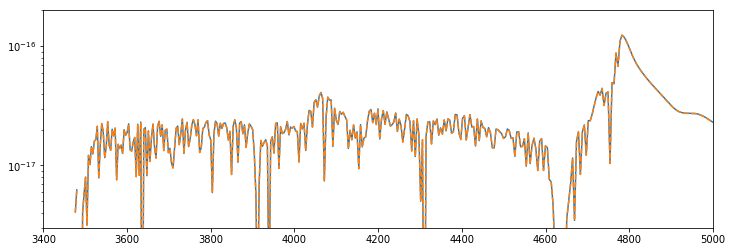

In [14]:
# plot the original and restored spectra for comparison
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,spec0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,2e-16)
xlim(3400,5000);#1e4);

In [15]:
# restore another spectrum
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

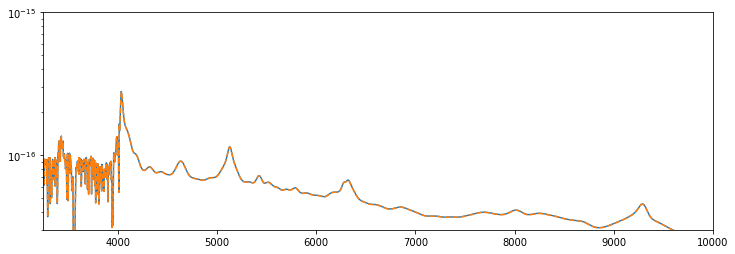

In [16]:
# and plot the comparison again
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-17,10e-16)
xlim(3250,1e4);

In [17]:
# rebuild all of the spectra
_,allspec = buildSpectraBulk(wave,qsos_restore)

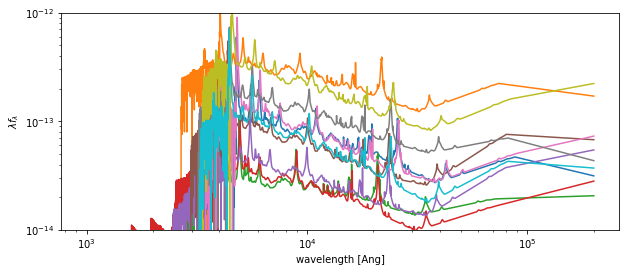

In [18]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);